# Машинное обучение, ФКН ВШЭ
## Практическое задание 10

### Общая информация

Дата выдачи: 22.04.2019

Мягкий дедлайн: 12.05.2019 08:00 MSK

Жёсткий дедлайн: 14.05.2019 23:59 MSK

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость», которая будет объявлена после жёсткого дедлайна. Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце Вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

В финальной версии ноутбука, которая отправляется для сдачи задания, должны быть быть выполнены следующие условия:
* все ячейки выполнены для представленной в ноутбуке версии кода;
* результаты выполнения ячеек отображены и согласованы с кодом;
* при повторном запуске ячеек результаты должны воспроизводиться с точностью до случайности.


### Формат сдачи

Задания сдаются через систему anytask. Посылка должна содержать:

* Ноутбук homework-practice-10-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

# Часть 1. Работа с данными


Мы будем работать с датасетом `20newsgroups`. В датасете содержится около 20 000 статей, разбитых на 20 классов. В ячейке ниже происходит загрузка датасета:

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [2]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(subset='all')
data = dataset["data"]
y = np.array(dataset["target"])
labels_names = {i: name for i, name in enumerate(dataset["target_names"])}

In [3]:
print("Target names: " + ", ".join(dataset["target_names"]))

Target names: alt.atheism, comp.graphics, comp.os.ms-windows.misc, comp.sys.ibm.pc.hardware, comp.sys.mac.hardware, comp.windows.x, misc.forsale, rec.autos, rec.motorcycles, rec.sport.baseball, rec.sport.hockey, sci.crypt, sci.electronics, sci.med, sci.space, soc.religion.christian, talk.politics.guns, talk.politics.mideast, talk.politics.misc, talk.religion.misc


Эти маски нам понадобятся позднее

In [120]:
train_mask = (np.random.uniform(size=len(data)) < 0.2)
test_mask = ~train_mask

**Задание 1**. Для работы с текстами нам нужно как-то построить их признаковое описание. По-простому это можно сделать как минимум тремя способами:
* посчитать tf-idf векторы;
* усреднить предобученные эмбеддинги (например, Word2Vec);
* обучить эмбеддинги самому (тот же Word2Vec) и усреднить их.

Кроме того, в каждом из этих случаев можно провести [стемминг](https://en.wikipedia.org/wiki/Stemming) токенов, а можно обойтись без него. Какие плюсы и минусы есть у стемминга?

В дальнейшем мы захотим обучить для этого датасета KMeans (мы надеемся, что в один кластер попадут документы с одной тематикой). Изучите датасет (его размер, размер текстов, тематики, пр.) и скажите, какие есть плюсы и минусы у каждого из трех описанных выше подходов.


In [5]:
import string
import nltk
import re
import gensim


class Prepare_machine:

    def __init__(self, data):
        self.data = data

    def remove_pattern(self, to_replace=None, to_regular=None):
        if to_replace is None and to_regular is None:
            raise Exeption("Empty argumets!")
        if to_replace is not None:
            def del_links(s):
                return s.replace(to_replace, '')
            self.data = self.data.apply(del_links)
        if to_regular is not None:
            def del_with_regular(s):
                return re.sub(to_regular, '', s, flags=re.MULTILINE)
            self.data = self.data.apply(del_with_regular)
        return self.data

    def remove_punctuation(self):
        def del_punctuation(s):
            return ''.join([l for l in s if l not in string.punctuation])
        self.data = self.data.apply(del_punctuation)
        return self.data

    def remove_numbers(self):
        def del_num(s):
            return ''.join([i for i in s if not i.isdigit()])
        self.data = self.data.apply(del_num)
        return self.data
    
    def tokenize(self, reg):
        self.data = self.data.apply(lambda s: s.lower())
        tokenizer = nltk.tokenize.RegexpTokenizer(reg)
        self.data = self.data.apply(lambda s: tokenizer.tokenize(s))
        return self.data

    def remove_stop_words(self):
        def del_stop_words(s):
            return [w for w in s if w not in nltk.corpus.stopwords.words('english')]
        self.data = self.data.apply(del_stop_words)
        return self.data

    def lemmatizing(self):
        lemmatizer = nltk.stem.WordNetLemmatizer()

        def lemm(s):
            return [lemmatizer.lemmatize(w) for w in s]
        self.data = self.data.apply(lemm)
        return self.data

    def stemming(self):
        stemmer = nltk.stem.porter.PorterStemmer()

        def stemm(s):
            return [stemmer.stem(w) for w in s]
        self.data = self.data.apply(stemm)
        return self.data

    def default_pipeline(self, to_replace=None, to_regular=None,
                         token_reg=None, short_words='lemm'):
        if short_words is not 'lemm' and short_words is not 'stemm':
            raise Exeption(f'Unknown tool: {short_words}')
        print('Removing patterns...')
        self.remove_pattern(to_replace=to_replace, to_regular=to_regular)
        print('Removing punctuation...')
        self.remove_punctuation()
        print('Removing numbers...')
        self.remove_numbers()
        print('Tokenizing...')
        self.tokenize(reg=token_reg)
        print('Removing stop words...')
        self.remove_stop_words()
        if short_words == 'stemm':
            print('Stemming...')
            self.stemming()
        else:
            print('Lemmatizing...')
            self.lemmatizing()
        print('Done!')
        return self.data

    def save_csv(self, name='data.csv'):
        self.data.to_csv(name)

In [6]:
data = pd.DataFrame(data)
data.columns = ['text'];
data.head()

,text
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...
4,From: Alexander Samuel McDiarmid <am2o+@andrew...


In [7]:
prep = Prepare_machine(data['text'])

prep.remove_pattern(to_regular = r"[a-zA-Z0-9.!#$%&'*+/=?^_`{|}~-]+@[a-zA-Z0-9](?:[a-zA-Z0-9-]{0,61}[a-zA-Z0-9])?(?:\.[a-zA-Z0-9](?:[a-zA-Z0-9-]{0,61}[a-zA-Z0-9])?)*")
prep.remove_pattern(to_regular=r"http\S+")
prep.remove_punctuation()
prep.remove_numbers()
prep.tokenize(reg = r'\w+')
prepared_data = prep.remove_stop_words()

In [8]:
prepared_data_stemm = prep.stemming()

__*Ответ:*__ Плюсом стемминга является его обобщающая способность, то есть слова с различными окончаниями после стемминга будут выглядеть одинаково. Минус - то что иногда мы теряем информацию вообще, так как у нас остаётся только пара букв например или окончания у слов могут вносить какую-то информацию, а обрезая окончаня мы её теряем.

**Задание 2**. Удалите из текстов email-адреса, приведите все к нижнему регистру, токенизируйте тексты с помощью `gensim.parsing.preprocessing.preprocess_string` (необходимые фильтры уже были импортированы) и обучите на полученных данных `gensim.models.word2vec.Word2Vec` с параметрами по умолчанию и 30 итерациями в обучении. Дополнительно обучите еще один Word2Vec на текстах с произведенным стеммингом, используйте `nltk.stem.porter.PorterStemmer`.

In [9]:
from gensim.models.word2vec import Word2Vec

w2v = Word2Vec(sentences = prepared_data, iter=30)

In [10]:
stemmed_w2v = Word2Vec(sentences = prepared_data_stemm,iter=30)

Напишите функцию, которая принимала бы на вход токенизированные тексты и для каждого текста возвращала бы усредненный эмбеддинг токенов. Если для какого-то токена в модели нет эмбеддинга, считайте его равным нулевому вектору.

In [11]:
def average_embedding(texts, embedder):
    '''
    texts -- список из списков токенов (каждый вложенный список соответствует тексту)
    embedder -- объект с полем wv, у которого определен оператор [], и с полем vector_size
    return: матрица усредненных эмбеддингов
    '''
    embedding_matrix = []
    size = w2v.vector_size
    for text in texts:
        embedding = np.zeros(size)
        for word in text:
            try:
                vec = embedder.wv.get_vector(word)
            except KeyError:
                vec = np.zeros(size)
            embedding += vec
        embedding_matrix.append(embedding / len(text))
    return np.array(embedding_matrix)

Воспользуйтесь этой функцией, чтобы составить матрицу средних word2vec-эмбеддингов для наших текстов.

In [12]:
w2v_enc = average_embedding(prepared_data, w2v)
w2v_enc_stemm = average_embedding(prepared_data_stemm, stemmed_w2v)

**Задание 3 (бонус, 0.5 баллов)**. Классической рекламой Word2Vec является "осмысленность арифметических действий" над эмбеддингами: утверждается, например, что $\text{embedding(king)} - \text{embedding(man)} + \text{embedding(woman)} \approx \text{embedding(queen)}$. Можете попробовать поискать такие отношения в вашей обученной модели. Получилось ли у вас что-нибудь найти? Подсказка: воспользуйтесь `w2v.wv.similar_by_vector`

In [13]:
w2v.wv.similar_by_vector(w2v.wv.get_vector('night') + w2v.wv.get_vector('light'))
#на третьем месте стоит morning что впринципе имеет какую-то логику

[('night', 0.8169876337051392),
 ('light', 0.7274390459060669),
 ('morning', 0.49655988812446594),
 ('pathologist', 0.48350587487220764),
 ('overnight', 0.48335200548171997),
 ('dark', 0.47185349464416504),
 ('lights', 0.46719861030578613),
 ('day', 0.4652200937271118),
 ('weather', 0.46403494477272034),
 ('shine', 0.46216249465942383)]

**Задание 4**. В дальнейшем нам понадобится уметь считать качество кластеризации, будем использовать supervised-метрики. Напишите функцию, вычисляющую BCubed-precision, BCubed-recall и BCubed-F1

In [9]:
from sklearn.metrics import precision_score, recall_score, f1_score

def bcubed_metrics(labels, clusters, show_result = True):
    '''
    labels -- настоящие метки документов
    clusters -- соответственно, кластеры для документов
    return: precision, recall, f1
    '''
    clusters_copy = clusters.copy()
    
    for uniq in np.unique(clusters):
        true_labels = labels[np.where(clusters == uniq)]
        uniques, counts = np.unique(true_labels, return_counts=True)
        most_offten = uniques[np.where(counts == max(counts))][0]
        
        clusters_copy[np.where(clusters == uniq)] = most_offten
    
    precision = precision_score(clusters_copy, labels,average='macro')
    recall = recall_score(clusters_copy, labels,average='macro')
    f1 = f1_score(clusters_copy, labels,average='macro')
    if show_result:
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')
        print(f'F1-score: {f1}')
    return precision, recall, f1

Чтобы понимать, насколько плохой/хорошей получилась кластеризация, нужно как минимум понимать, насколько она лучше случайной кластеризации. Случайно кластеризуйте объекты и посчитайте метрики.

In [95]:
rand_prediction = np.random.randint(20,size = len(y))
bcubed_metrics(y, rand_prediction);

Precision: 0.06332238327582462
Recall: 0.03948023209194468
F1-score: 0.0476095602435885


Напишите функцию, которая рисовала бы график распределения меток в каждом из кластеров, например, как на картинке.
<img src="example.png" align="center">

In [16]:
import matplotlib.pyplot as plt
def plot_labels_distribution(labels, clusters, labels_names = None):
    '''
    labels -- настоящие классы документов
    clusters -- соответственно, кластеры для документов
    labels_names -- словарь, сопоставляющий индексу класса его название
    '''
    tab20 = plt.cm.get_cmap('tab20')
    colors = []
    for n in range(20):
        colors.append(tab20(1/20 *(n+1)))
    plt.figure(figsize=(16,9))
    
    for uniq in np.unique(clusters):
        true_labels = labels[np.where(clusters == uniq)]
        uniques, counts = np.unique(true_labels, return_counts=True)
        counts = counts / sum(counts)
        bottom = 0
        
        for num in range(len(counts)):
            bar = plt.bar(uniq, counts[num], bottom=bottom, color = tab20(1/20 *(uniques[num]+1)))
            bottom += counts[num]
    if labels_names is not None:
        plt.legend(labels_names,bbox_to_anchor=(1.2, 1))
    else:
        plt.legend(range(20))
plot_labels_distribution(y, rand_prediction, labels_names=list(labels_names.values()))

# Часть 2. Кластеризация

**Задание 5**. Обучите на усредненных word2vec-векторах (и для текстов со стеммингом, и без него) KMeans на 20 кластеров (с параметрами по умолчанию), измерьте качество кластеризации (BCubed-метрики) и постройте график распределения меток по кластерам. Попробуйте поперебирать параметры KMeans, не меняя число кластеров. Получилось ли у вас добиться сильного выигрыша?

In [96]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=20)
prediction = kmeans.fit_predict(w2v_enc)
bcubed_metrics(y, prediction);

Precision: 0.41041155245366073
Recall: 0.39300938923432516
F1-score: 0.3866561408549374


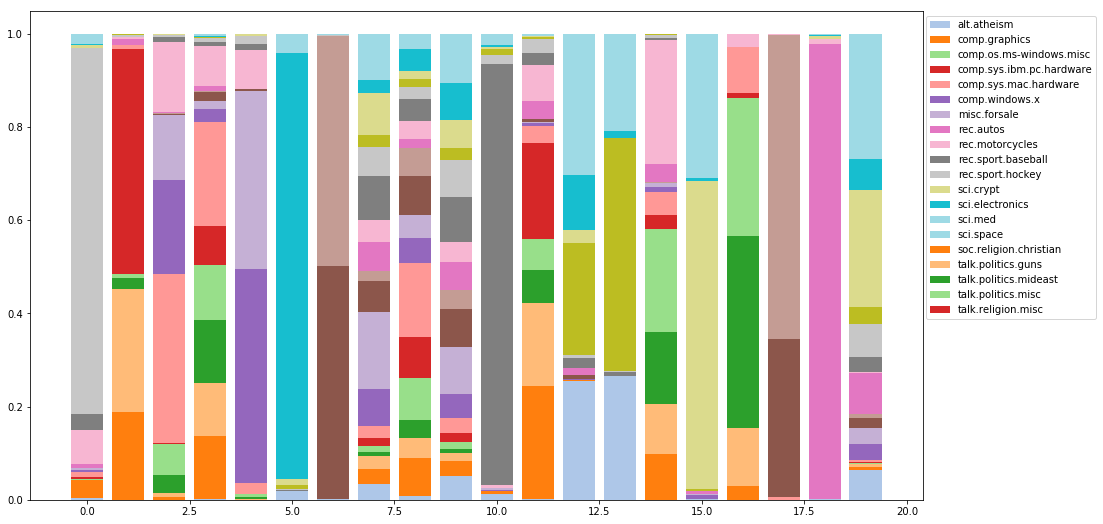

In [18]:
plot_labels_distribution(y, prediction, labels_names=list(labels_names.values()))

In [97]:
prediction_stemm = kmeans.fit_predict(w2v_enc_stemm)
bcubed_metrics(y, prediction_stemm);

Precision: 0.42640330942444793
Recall: 0.4089499337281494
F1-score: 0.3973826895491099


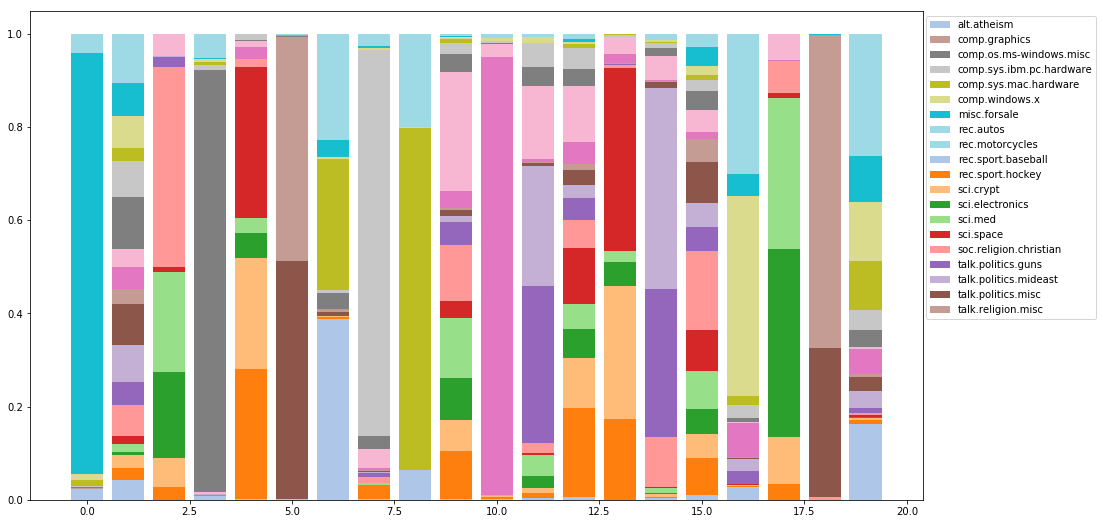

In [20]:
plot_labels_distribution(y, prediction_stemm, labels_names=list(labels_names.values()))

Помог ли стемминг улучшить качество кластеризации? Насколько сильно?

**_Ответ_**:

Все следующие эксперименты проводите на текстах без стемминга. 

**Задание 6**. Скорее всего, выигрыш оказался очень маленьким. Возможно, в усредненных word2vec-векторах содержится слишком мало информации, и этим объясняется низкое качество модели? Чтобы проверить это, обучите логистическую регрессию на предсказание настоящих меток документов. Для разбиения на обучающую и тестовую выборки воспользуйтесь масками `train_mask`, `test_mask`. Измерьте BCubed-метрики на тестовой части для кластеризации и логистической регрессии. Для кластеризации также постройте график распределения меток по кластерам.

In [72]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(w2v_enc[train_mask], y[train_mask])

Precision: 0.7622081208141901
Recall: 0.7671338632225739
F1 score: 0.7599679254082907


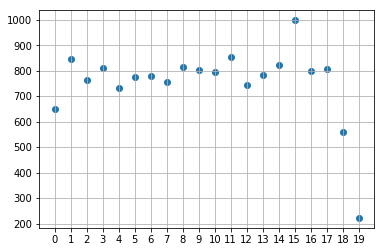

In [22]:
print(f"Precision: {precision_score(logreg.predict(w2v_enc[test_mask]), y[test_mask],average='macro')}")
print(f"Recall: {recall_score(logreg.predict(w2v_enc[test_mask]), y[test_mask],average='macro')}")
print(f"F1 score: {f1_score(logreg.predict(w2v_enc[test_mask]), y[test_mask],average='macro')}")
values, counts = np.unique(logreg.predict(w2v_enc[test_mask]), return_counts=True)
plt.scatter(values, counts)
plt.xticks(range(20))
plt.grid();

Посмотрите на размер кластеров. Сильно ли они отличаются друг от друга? Есть ли очень большие или очень маленькие кластеры?

/home/hacket/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/hacket/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Precision: 0.7641356239541709
Recall: 0.7693645094774807
F1 score: 0.7603004562640213


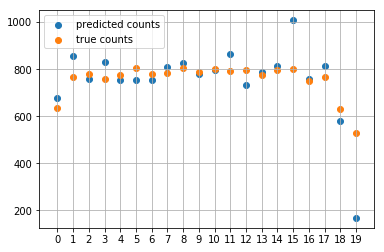

In [24]:
logreg.fit(w2v_enc_stemm[train_mask], y[train_mask])
print(f"Precision: {precision_score(logreg.predict(w2v_enc_stemm[test_mask]), y[test_mask],average='macro')}")
print(f"Recall: {recall_score(logreg.predict(w2v_enc_stemm[test_mask]), y[test_mask],average='macro')}")
print(f"F1 score: {f1_score(logreg.predict(w2v_enc_stemm[test_mask]), y[test_mask],average='macro')}")
values, counts = np.unique(logreg.predict(w2v_enc_stemm[test_mask]), return_counts=True)
plt.scatter(values, counts)
values, counts = np.unique(y[test_mask], return_counts=True)
plt.scatter(values, counts)
plt.legend(['predicted counts','true counts'])
plt.xticks(range(20))
plt.grid();

Можно ли объяснить плохую кластеризацию тем, что усредненный Word2Vec - слишком плохое признаковое пространство? Если такого утверждения сделать нельзя, дело может быть в слишком похожих метках документов. Попробуйте оставить в выборках только документы с 7 сильно отличающимися классами. Обучите KMeans и логистическую регрессию на этих данных; изменился ли зазор между кластеризацией и классификацией?

In [62]:
distinct_labels = {
    "comp.graphics", "rec.autos", "rec.sport.baseball",
    "sci.space", "sci.med", "soc.religion.christian", "talk.politics.guns"
}

names_labels =  {y:x for x,y in labels_names.items()}
classes = []
for dist in distinct_labels:
    classes.append(names_labels[dist])

f = np.vectorize(lambda x: x in classes)

w2v_enc_distinct = w2v_enc[f(y)]
print(w2v_enc_distinct.shape)
w2v_enc_stemm_distinct = w2v_enc_stemm[f(y)]
print(w2v_enc_stemm_distinct.shape)
y_distinct = y[f(y)]
print(y_distinct.shape)

(6841, 100)
(6841, 100)
(6841,)


In [63]:
train_mask_distinct = (np.random.uniform(size=len(y_distinct)) < 0.2)
test_mask_distinct = ~train_mask_distinct

In [67]:
logreg.fit(w2v_enc_distinct[train_mask_distinct], y_distinct[train_mask_distinct])
print("W2v encodings")
print(f"Precision: {precision_score(logreg.predict(w2v_enc_distinct[test_mask_distinct]), y_distinct[test_mask_distinct],average='macro')}")
print(f"Recall: {recall_score(logreg.predict(w2v_enc_distinct[test_mask_distinct]), y_distinct[test_mask_distinct],average='macro')}")
print(f"F1 score: {f1_score(logreg.predict(w2v_enc_distinct[test_mask_distinct]), y_distinct[test_mask_distinct],average='macro')}")

logreg.fit(w2v_enc_stemm_distinct[train_mask_distinct], y_distinct[train_mask_distinct])
print("\nW2v encodings + stemming")
print(f"Precision: {precision_score(logreg.predict(w2v_enc_stemm_distinct[test_mask_distinct]), y_distinct[test_mask_distinct],average='macro')}")
print(f"Recall: {recall_score(logreg.predict(w2v_enc_stemm_distinct[test_mask_distinct]), y_distinct[test_mask_distinct],average='macro')}")
print(f"F1 score: {f1_score(logreg.predict(w2v_enc_stemm_distinct[test_mask_distinct]), y_distinct[test_mask_distinct],average='macro')}")

W2v encodings
Precision: 0.935487926658776
Recall: 0.9359683811424867
F1 score: 0.9356267161814571

W2v encodings + stemming
Precision: 0.9438007073713416
Recall: 0.9441083749514786
F1 score: 0.943859970763448


In [105]:
kmeans = KMeans(n_clusters=20)
prediction = kmeans.fit_predict(w2v_enc_distinct)
print('KMeans + w2v encodings')
bcubed_metrics (y_distinct, prediction);

prediction = kmeans.fit_predict(w2v_enc_stemm_distinct)
print('\nKMeans + w2v encodings + stemming')
bcubed_metrics (y_distinct, prediction);

KMeans + w2v encodings
Precision: 0.7986957256416616
Recall: 0.8353018442259083
F1-score: 0.8011665154595959

KMeans + w2v encodings + stemming
Precision: 0.81356403325685
Recall: 0.8453084308340157
F1-score: 0.8190614570272384


Ответьте на вопросы:
1. Судя по графикам, какие классы сложно отделяются от других? Какие классы похожи друг на друга? Какие классы легко отделяются от других?
2. Возросли ли метрики у кластеризации при отборе 7 отличных друг от друга меток?
3. Возросли ли метрики у классификации при отборе 7 отличных друг от друга меток? Почему?
4. Можно ли объяснить плохую кластеризацию неудачным признаковым пространством? Схожестью меток?

**_Ответ:_**  
1. Классы talk.religion.misc и soc.religion.christian отличались хуже всего, исходя из разницы в количсестве предсказанных и правильных меток.
Лучше всего отделялись классы 9 10 16 rec.sport.baseball, rec.sport.hockey и talk.politics.guns
2. Да  
3. Да, предполагаю что темы talk.politics.guns и talk.religion.misc коррелировали, а после того как один из них убрали качество классификации возрасло.  
4. Если бы использовалась косинусная мера, то возможно качество возрасло. Вероятно что схожесть меток создает кластеры сложной формы, которые будет проще обнаружить методами основанными на плотностях.

# Часть 3. Latent Dirichlet Allocation

**Задание 7**. Обучать LDA на тех текстах, которые мы сейчас имеем, - очень медленно, поскольку в них очень много уникальных слов. Чтобы это исправить, мы оставим в текстах только те слова, которые чаще всего встречаются в нашем корпусе. Напишите функцию, которая принимает на вход тексты и количество слов, которые нужно оставить, и выкидывает слова, которые не попали в _глобальный_ топ по всему корпусу:

In [10]:
from collections import Counter

def leave_top_words(texts, n_words):
    '''
    texts -- набор текстов (список списков токенов)
    n_words -- сколько слов из топа нужно оставить
    return: набор текстов с удаленными словами, которые не вошли в топ
    '''    
    text = np.concatenate(texts)
    most_common = list(dict(Counter(text).most_common(n_words)).keys())
    
    def rm_words(text):
        new_text = []
        for word in text:
            if word in most_common:
                new_text.append(word)
        return new_text
    
    return texts.apply(rm_words)

Сделайте два набора текстов: в одном оставьте 3000 слов, а в другом 6000 слов.

In [11]:
prepared_3000 = leave_top_words(prepared_data,n_words=3000);

In [12]:
prepared_6000 = leave_top_words(prepared_data,n_words=6000);

Обучите `gensim.models.ldamodel.LdaModel` (для этого вам также понадобится `gensim.corpora.Dictionary`) с 20 темами на обоих наборах текстов.

In [13]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel

dictionary_3000 = Dictionary(prepared_3000)
corpus_3000 = [dictionary_3000.doc2bow(text) for text in prepared_3000]
lda_3000 = LdaModel(corpus_3000, num_topics=20)

dictionary_6000 = Dictionary(prepared_6000)
corpus_6000 = [dictionary_6000.doc2bow(text) for text in prepared_6000]
lda_6000 = LdaModel(corpus_6000, num_topics=20)

Метод `inference` в LDA возвращает для каждого текста вероятности тем. Напишите функцию, которая принимала бы обученную LDA-модель и корпус, возвращая самый вероятный топик для каждого текста. Убедитесь, что разница в качестве (по BCubed) между наборами на 3000 и 6000 слов незначительна. Это будет означать, что можно работать с набором на 3000 слов.

In [14]:
def get_topics(lda_model, corpus):
    '''
    lda_model -- обученный инстанс LdaModel
    corpus -- корпус
    return: наиболее вероятный топик для каждого текста из корпуса
    '''
    answer = []
    for corp in corpus:
        answer.append(np.argmax(lda_model.inference([corp])[0][0]))
    return answer

In [15]:
answer_3000 = get_topics(lda_3000, corpus_3000)
answer_6000 = get_topics(lda_6000, corpus_6000)

In [16]:
bcubed_metrics(y, np.array(answer_3000));
print('\n')
bcubed_metrics(y, np.array(answer_6000));

Precision: 0.34315178086032755
Recall: 0.29144110291512315
F1-score: 0.297065457352093


Precision: 0.4275241516754442
Recall: 0.3712601023494596
F1-score: 0.3729574242427387


**Задание 8**. Попытайтесь выбить из LDA больше качества. Для этого переберите по полной квадратной сетке параметры `iterations` и `num_passes` (скажем, по сетке 3х3, не стоит ставить слишком большие значения). Для каждой модели посчитайте ELBO и bcubed-метрики и сохраните их: они нам понадобятся в дальнейшем. Постройте графики зависимости ELBO от `iterations` при разных `num_passes` (3 кривые на одном графике) и наоборот.

In [24]:
params = {'iterations':[60,70,80],
          'num_passes':[1,2,3]}
models = {}
metrics = []
for iteration in params['iterations']:
    for num_pass in params['num_passes']:
        models[f'iter:{iteration} passes:{num_pass}'] = LdaModel(corpus_6000,
                                                                 iterations=iteration,
                                                                passes=num_pass)
        metrics.append(bcubed_metrics(y, np.array(get_topics(models[f'iter:{iteration} passes:{num_pass}'], corpus_6000)),
                                      show_result=False))

In [42]:
names = []
for iteration in params['iterations']:
    for num_pass in params['num_passes']:
        names.append(f'iter:{iteration} passes:{num_pass}')
metrics_d = dict(zip(names,metrics))

Постройте график зависимости BCubed-F1 от ELBO. Для лучшей (по BCubed-F1) LDA-модели постройте график распределения меток в кластерах.

In [53]:
bounds = []
for model in list(models.values()):
    bounds.append(model.bound(corpus_6000))

In [60]:
metrics

[(0.43701285368599996, 0.45782701243845636, 0.43679358844663707),
 (0.4392195015807815, 0.4842624959584878, 0.4347089976087094),
 (0.4060453549095315, 0.4413825646914703, 0.39811670446560415),
 (0.4144969897519747, 0.40988048412273753, 0.3988974108450324),
 (0.45558716863769355, 0.49801486282624285, 0.4540950458859835),
 (0.42830414670503314, 0.4732746251248402, 0.43012713139952935),
 (0.4350175728122755, 0.45697464597506327, 0.43712162631221174),
 (0.40550952902366744, 0.4279481336054009, 0.39790212988354534),
 (0.4474327397559724, 0.4983605955105889, 0.4505548920100835)]

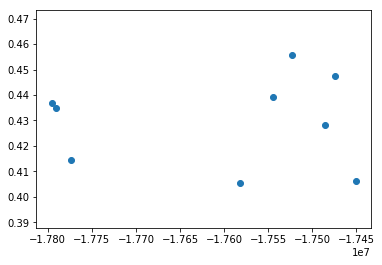

In [59]:
plt.scatter(bounds, np.array(metrics)[:,0]);

Ответьте на вопросы:
1. Посмотрите на размер кластеров в LDA. Сильно ли они отличаются друг от друга? Есть ли очень большие или очень маленькие кластеры?
2. Как влияют на ELBO `iterations` и `passes`? 
3. Есть ли какая-нибудь зависимость между ELBO и BCubed-F1? Можем ли мы обучать LDA, смотря только на ELBO?
4. Сравните тематическое моделирование при помощи LDA и кластеризацию при помощи KMeans.

**Задание 9**. С помощью `pyLDAvis.gensim` визуализируйте найденные моделью темы и попытайтесь описать некоторые из них.

In [62]:
import pyLDAvis.gensim as gensimvis
import pyLDAvis

In [94]:
vis_data = gensimvis.prepare(lda_6000, corpus_6000, dictionary_6000)
pyLDAvis.display(vis_data)

# Часть 4. Три подхода к обучению

**Задание 10**. Вы обучили две unsupervised-модели и, скорее всего, не получили очень хорошего качества. Более того, вы попытались обучить логистическую регрессию на небольшом количестве размеченных данных и, скорее всего, получили качество заметно лучше. Попробуйте теперь обучить логистическую регрессию на tf-idf векторах. Сравните качество с логистической регрессией на усредненных word2vec-векторах. Для разбиения на обучающую и тестовую выборки пользуйтесь масками `train_mask` и `test_mask`.

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer

def glue(a):
    s = ''
    for w in a:
        s = s + ' ' + w
    return s
tfidf = TfidfVectorizer()
X_tfidf = tfidf.fit_transform(prepared_data.apply(glue))

In [151]:
X_train = X_tfidf[test_mask]
y_train = y[test_mask]
X_test = X_tfidf[train_mask]
y_test = y[train_mask]

In [152]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [153]:
print(f"Precision: {precision_score(logreg.predict(X_test), y_test,average='macro')}")
print(f"Recall: {recall_score(logreg.predict(X_test), y_test,average='macro')}")
print(f"F1 score: {f1_score(logreg.predict(X_test), y_test,average='macro')}")

Precision: 0.8978460696555931
Recall: 0.9064728786911136
F1 score: 0.8989635226220265


Попробуем применить semi-supervised подход. На тех же данных примените self-training метод, в основе которого лежит логистическая регресиия. Напомним, что это означает:

1. Обучаем модель на размеченной выборке;
2. Применяем модель к неразмеченной выборке, выбираем некоторое количество объектов, в которых модель уверена больше всего. Добавляем к размеченной выборке эти объекты, присваивая им метки, которые предсказала модель;
3. Повторяем несколько раз.

В качестве неразмеченной части возьмите тестовую выборку. Посчитайте метрики

In [216]:
from scipy.sparse import vstack

X_train_new = X_train
y_train_new = y_train
X_test_new = X_test
y_test_new = y_test
metrics = []
for i in range(5):
    logreg.fit(X_train_new, y_train_new)
    y_pred = logreg.predict(X_test_new)
    metrics.append((precision_score(logreg.predict(X_test_new), y_test_new,average='macro'),
                    recall_score(logreg.predict(X_test_new), y_test_new,average='macro'),
                    f1_score(logreg.predict(X_test_new), y_test_new,average='macro')))
    X_new = X_test_new[np.where(np.max(logreg.predict_log_proba(X_test_new), axis = 1) > -0.30)]
    y_new = y_test_new[np.where(np.max(logreg.predict_log_proba(X_test_new), axis = 1) > -0.30)]
    X_test_new = vstack([X_test_new, X_new])
    y_test_new = np.hstack([y_test_new, y_new])
    

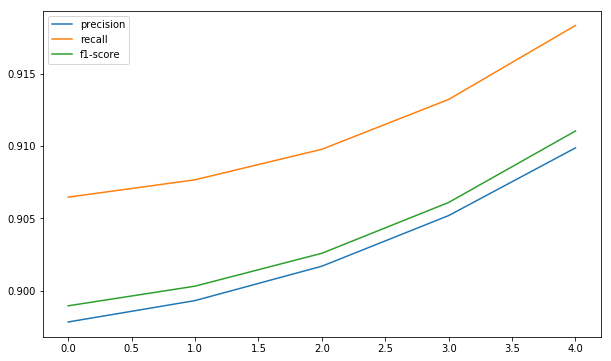

<Figure size 432x288 with 0 Axes>

In [215]:
metrics = np.array(metrics)
plt.figure(figsize=(10,6))
plt.plot(metrics[:,0])
plt.plot(metrics[:,1])
plt.plot(metrics[:,2])
plt.legend(['precision','recall','f1-score'])
plt.figure();

Ответьте на вопросы:
1. Как методы ранжируются по итоговому качеству? Почему именно так?
2. На каком признаковом пространстве логистическая регрессия дает лучшее качество? Почему?

**_Ответ_**: качество на ff-idf векторах оказалось хуже, чем на w2v, так как в w2v учитывается взаимодействие между словами как таковыми, в то время как tf-idf описывает отношение слова к тематике